# Data Mining Project

* Alex Panchot (M20190546)
* Hugo Mentzingen (M20190215)
* Rennan Valadares (M20190146)

In [163]:
#remove warnings
import warnings
warnings.filterwarnings("ignore")

#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.regression import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.svm import LinearSVR
from sklearn import preprocessing
from scipy.spatial.distance import euclidean
from sklearn.tree import DecisionTreeRegressor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import k_means


In [164]:
#Global variables

env_params = {
    "InsConColumns" : ['Premiums in LOB: Motor',
                       'Premiums in LOB: Household',
                       'Premiums in LOB: Health',
                       'Premiums in LOB:  Life',
                       'Premiums in LOB: Work Compensations',
                       'Premium: Sum'],
    "ValEngColumns" : ['Educational Degree',
                       'Geographic Living Area',
                       'Has Children (Y=1)',
                       'Gross Monthly Salary',
                       'Customer Monetary Value',
                       'First Policy´s Age'],
    "CategoricalColumns" : ['Educational Degree',
                            'Geographic Living Area',
                            'Has Children (Y=1)'],
    "NumericalColumns" : ['First Policy´s Year',
                          'Gross Monthly Salary',
                          'Customer Monetary Value',
                          'Claims Rate',
                          'Premiums in LOB: Motor',
                          'Premiums in LOB: Household',
                          'Premiums in LOB: Health',
                          'Premiums in LOB:  Life',
                          'Premiums in LOB: Work Compensations',
                          'Age',
                          'First Policy´s Age',
                          'Premium: Sum']
}

In [165]:
#Function to split the DataFrame in data complete (without NaNs on the same row) and incomplete
#The rows that belong to the 'incomplete' dataframe have at least one NaN

def split(data_insurance, reset_index = False):
    data_insurance_complete = pd.DataFrame()
    data_insurance_incomplete = data_insurance[data_insurance.isna().any(axis=1)]
    if reset_index:
        data_insurance_incomplete.reset_index(inplace=True)
        data_insurance_incomplete.drop('index', axis=1, inplace=True)
    data_insurance_complete = data_insurance[~data_insurance.isna().any(axis=1)]
    return data_insurance_complete, data_insurance_incomplete

In [166]:
#Function to plot the histogram of a variable (feature)

def histogram(df, features):

    fig = plt.figure(figsize=(12, 20))
    
    for i, feature in enumerate(features):
    
        # Set up the plot
        ax = fig.add_subplot((len(features)//3)+1, 3, i + 1)
        
        # Draw the plot
        ax.hist(df[feature], bins = 50,
                 color = 'blue', edgecolor = 'black')

        # Title and labels
        ax.set_title('Histogram of ' + feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Customers')

    plt.subplots_adjust(hspace = 0.2)
    plt.show()

In [167]:
#Function to plot the correlation between variables

def plotCorrelation(df):
    sns.set()
    fig, ax = plt.subplots(figsize=(9,6))
    plt.rcParams.update({'font.size': 11})
    sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f', cmap='RdBu', vmin=-1, vmax=1, linewidths=.9, ax = ax).set_title('Variables correlation')
    ax.set_xticks(np.arange(df.corr(method='pearson').shape[1]+1), minor=True)
    ax.set_yticks(np.arange(df.corr(method='pearson').shape[0]+1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=True, left=True)

In [168]:
#Function to separate the dataframe into 'Insurance Consumption' and 'Value & Engagement' features

def separateVariables(df):
    InsCon = df[env_params['InsConColumns']]
    ValEng = df[env_params['ValEngColumns']]

    return InsCon, ValEng

In [169]:
#Function to perform outliers removal based on interquartile range (IQR) 

def removeOutliers(df, cutoff1, cutoff2, special_features):
    
    outliers_to_remove = []
    for feature in env_params['NumericalColumns']:
        if feature in df:
            #calculate interquartile range
            q25, q75 = np.nanpercentile(df[feature], 25), np.nanpercentile(df[feature], 75)
            iqr = q75 - q25
            print(feature)
            print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        
            #calculate the outlier cutoff
            if feature not in special_features:
                cut_off = iqr * cutoff1
                lower, upper = q25 - cut_off, q75 + cut_off
            else:
                cut_off = iqr * cutoff2
                lower, upper = q25 - cut_off, q75 + cut_off
        
            #identify outliers
            outliers = [index for index, value in df[feature].iteritems() if value < lower or value > upper]
            print('Identified outliers: %d' % len(outliers))
            outliers_to_remove += outliers
    outliers_to_remove = set(outliers_to_remove)
    outliers_to_remove = sorted(outliers_to_remove)
    return outliers_to_remove

In [170]:
#Function to rescale the dataframe columns

def rescale(data_insurance):
    
    data_insurance_ = deepcopy(data_insurance)

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data_insurance_.drop(columns=env_params['CategoricalColumns'], axis = 1))
    scaled_features = pd.DataFrame(scaled_features, columns = data_insurance_.drop(columns=env_params['CategoricalColumns']).columns)
    scaled_data_insurance = pd.merge(scaled_features, data_insurance_[env_params['CategoricalColumns']], left_index=True, right_index=True)

    return scaled_data_insurance

In [171]:
#Function to evaluate the best n_neighbors to use with KNN

def evaluateClassifier(data_insurance):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance, reset_index=True)

    def createAndFitClassifier(k):
        clf = KNeighborsClassifier(n_neighbors=k)    
        incomplete = deepcopy(data_insurance_incomplete)
        complete = deepcopy(data_insurance_complete)   
        X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != value].values,
                                                            complete.loc[:,value].values, test_size = 0.2, random_state = 0)
        trained_model = clf.fit(X_train, y_train)
        result = [clf, y_test, X_test, trained_model, incomplete, complete]
        return result
    
    accuracies_for_value_dict = {}

    for index, value in enumerate(env_params['CategoricalColumns']):

        accuracy_dict = {}

        for k in range(3,100):

            result = createAndFitClassifier(k)
            clf = result[0]
            y_test = result[1]
            X_test = result[2]                                                
            
            #calculate the model accuracy and storing the value into a dictionary
            y_pred = clf.predict(X_test)
            accuracy_matrix = confusion_matrix(y_test, y_pred)
            accuracy = accuracy_matrix.trace()/accuracy_matrix.sum()
            accuracy_dict[k] = accuracy
        
        accuracies_for_value_dict[value] = accuracy_dict
    
    return accuracies_for_value_dict


In [172]:
#Function that uses KNN to classify the missing values on CATEGORICAL columns

def classifyCategoricalData(data_insurance, n_neighbors_dict):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance, reset_index=True)
  
    #Creating a classifier to fill the categorical data: Educational Degree, Geographic Living Area and Has Children (Y=1)
      
    for index, value in enumerate(env_params['CategoricalColumns']):

        if value in n_neighbors_dict:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors_dict[value])    
        
            incomplete = deepcopy(data_insurance_incomplete)
            complete = deepcopy(data_insurance_complete)
        
            X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != value].values,
                                                            complete.loc[:,value].values, test_size = 0.2, random_state = 0)
        
            trained_model = clf.fit(X_train, 
                                 y_train)
           
            #fill the numerical columns with the column mean
            incomplete.loc[:, ~incomplete.columns.isin(env_params['CategoricalColumns']) ] = incomplete.loc[:, 
                                ~incomplete.columns.isin(env_params['CategoricalColumns'])].apply(lambda column: column.fillna(column.mean()), axis=0)
        
            #Round Age and First Policy's Year
            #incomplete['Age'] = incomplete['Age'].apply(lambda x:round(x))
            incomplete['First Policy´s Age'] =  incomplete['First Policy´s Age'].apply(lambda x:round(x))
                
            #Categorical columns with the exception of the one we want to predict
            cat_without_the_column = deepcopy(env_params['CategoricalColumns'])
            cat_without_the_column.pop(index)
        
            #Fill the categorical columns with the exception of the one we want to predict with the mode
            incomplete.loc[:, incomplete.columns.isin(cat_without_the_column) ] = incomplete.loc[:, 
                        incomplete.columns.isin(cat_without_the_column)].apply(lambda column: column.fillna(int(column.mode())), axis=0)
              
            prediction = trained_model.predict(incomplete.loc[:,incomplete.columns != value])
            temp_df = pd.DataFrame(prediction.reshape(-1,1), columns = [value])
        
        
            #now we are filling data_insurance_incomplete 
            for ind in range(len(temp_df)):
                if np.isnan(data_insurance_incomplete[value][ind]):
                    data_insurance_incomplete[value][ind] = temp_df[value][ind]


        #and reconstructing the original dataframe
        dataset = pd.concat([data_insurance_complete, data_insurance_incomplete])
        dataset.set_index(dataset['Customer Identity'] - 1, inplace=True)
    
    return dataset

In [173]:
#funcion for checking which algorithm is the best for using on each column for NUMERICAL columns

def checking_choices(data_insurance, number_of_tests=10):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance)

    choices = []
    better_for_each_column = []
    test_errors = {}
    
    #testing
    for i in range(number_of_tests):
        test, error_list = regressor_test(data_insurance)
        choices.append(test)
        test_errors.update({'Test: '+ str(i):error_list})
        
    #chosing the best algorithm for each column
    for i in range(len(data_insurance.columns)):
        l = []
        for j in range(len(choices)):
            l.append(choices[j][i])
        better_for_each_column.append(max(set(l), key = l.count))
    #return the better algorithm for each column, and the error list    
    return better_for_each_column, test_errors

In [174]:
#function for test which regressor is best for each numerical column
#Return a list of lists with the best algorithm for each test (choose the number of tests on checking_choices function )

def regressor_test(data_insurance):
#variables to hold the Mean Squared Errors for each model
    dt_errors = []
    linear_errors = []
    svr_errors = []    
    
    complete,incomplete = split(data_insurance)
    
    for i in complete.columns:
        i = complete.columns[0]
        X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != i].values,
                                                            complete.loc[:,i].values, test_size = 0.2, random_state = 0)
        
        regressor1 = DecisionTreeRegressor(min_samples_split=112,min_samples_leaf=9)
        regressor2= LinearRegression()
        regressor3=LinearSVR()
        
        
        DT_Model = regressor1.fit(X_train, 
                                 y_train)
        Linear_trained_model2 = regressor2.fit(X_train, 
                                 y_train)
        SVR_trained_model3 = regressor3.fit(X_train, 
                                 y_train)  
        
        incomplete_2 = deepcopy(incomplete)
        incomplete_2.loc[:, incomplete.columns != i] = incomplete_2.loc[:, 
                                incomplete.columns != i].apply(lambda row: row.fillna(row.mean()), axis=1)

        y_pred1 = regressor1.predict(X_test)
        y_pred2 = regressor2.predict(X_test)
        y_pred3 = regressor3.predict(X_test)
        
        
        dt_errors.append(regressor1.score(X_test, y_test))
        linear_errors.append(regressor2.score(X_test, y_test))
        svr_errors.append(regressor3.score(X_test, y_test))
        
        
    errors_dict = {}
    errors_dict.update({"KN-Errors": dt_errors})
    errors_dict.update( {"Linear-Errors": linear_errors})
    errors_dict.update( {"SVR-Errors": svr_errors})


    #ROOT MEAN SQUARED ERROR 
    R2 = []

    #Filling R Squared for each column
    for i in range(0, len(complete.columns)):
        l = []
        l.extend((dt_errors[i], linear_errors[i], svr_errors[i]))
        
        if min(l) == dt_errors[i]:
            R2.append("KNN")
        elif min(l) == linear_errors[i]:
            R2.append("Linear")
        elif min(l) == svr_errors[i]:
            R2.append("SVR")
    


    return R2, errors_dict

In [175]:
#function to apply the regressors

def apply_regressors(choices, data_insurance, numerical_columns):

    complete,incomplete = split(data_insurance)

    for i,v in enumerate(complete.columns):
        
        #Check if it is a numerical column
        if v in numerical_columns:
            
            #use the choosen algorithm 
            if choices[i] == 'KNN':
                regressor = KNeighborsRegressor(5, 
                                                weights ='distance', 
                                                metric = 'euclidean')
            elif choices[i] == 'SVR':
                regressor = LinearSVR()
                
            elif choices[i] == 'Linear':
                regressor = LinearRegression()
                
            #Split in train-test data    
            X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != v].values,
                                                                complete.loc[:,v].values, test_size = 0.2, random_state = 0)
            #Train the model
            trained_model = regressor.fit(X_train, 
                                     y_train)
            
            #Make predictions
            incomplete_2 = deepcopy(incomplete)
            incomplete_2.loc[:, incomplete.columns != v] = incomplete_2.loc[:, 
                                    incomplete.columns != v].apply(lambda row: row.fillna(row.mean()), axis=1)
            
            prediction = trained_model.predict(incomplete_2.loc[:,incomplete_2.columns != v])
            temp_df = pd.DataFrame(prediction.reshape(-1,1), columns = [v])
            
            #fill NaN's on data_arrivals_incomplete 
            for index in range(len(temp_df)):
                if np.isnan(incomplete.iloc[index,i]):
                    incomplete.iloc[index,i] = temp_df[v][index]



    #and filling the nan's on arrivals_df
    dataset = pd.concat([complete, incomplete])
    dataset.set_index(dataset['Customer Identity'] - 1, inplace=True)
    
    
    return dataset

In [176]:
#Given two features (columns) this function plots a quartile matrix (number of customer on each quartile cell)

def quartileMatrix(df, feature1, feature2):
  quartile_id = ['q1','q2','q3','q4']
  df['f1_quartile'] = pd.qcut(df[feature1], 4, quartile_id)
  df['f2_quartile'] = pd.qcut(df[feature2], 4, quartile_id)
  quartiles_df = pd.DataFrame(index=quartile_id, columns=quartile_id)

  for i in quartile_id:
      for j in quartile_id:
          quartiles_df.ix[i,j] = len(df[(df["f1_quartile"]==i) & (df["f2_quartile"]==j)])
  
  return quartiles_df
 


In [177]:
#_________________________Cleaning and Filling the Data with the algorithms___________________________________________

#Read the dataset
insurance_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1dCJHxjPPob8sEfyY6ddja0DeYpos5Uq7')

#Create Age column
insurance_df['Age'] = insurance_df.loc[:, 'Brithday Year'].apply(lambda x : 2018 - x )

#Create First Policy´s Age column
insurance_df['First Policy´s Age'] = insurance_df.loc[:, 'First Policy´s Year'].apply(lambda x : 2018 - x )

#Drop Birthday Year and First Policy´s Year
insurance_df.drop(['Brithday Year', 'First Policy´s Year' ], axis=1, inplace=True)

#Adding the sum of all premiums paid as a column 
insurance_df['Premium: Sum']=insurance_df[['Premiums in LOB: Work Compensations',
                                                         'Premiums in LOB:  Life',
                                                         'Premiums in LOB: Health',
                                                         'Premiums in LOB: Household',
                                                         'Premiums in LOB: Motor']].sum(axis=1)

In [178]:
#Count the number of rows with NaNs
rows_with_nans = insurance_df.shape[0] - insurance_df.dropna().shape[0]
print(rows_with_nans)
print(rows_with_nans/insurance_df.shape[0])

309
0.030011655011655012


In [179]:
outliers = removeOutliers(insurance_df, 1.5, 1.5, [])

Gross Monthly Salary
Percentiles: 25th=1706.000, 75th=3290.250, IQR=1584.250
Identified outliers: 2
Customer Monetary Value
Percentiles: 25th=-9.440, 75th=399.778, IQR=409.218
Identified outliers: 110
Claims Rate
Percentiles: 25th=0.390, 75th=0.980, IQR=0.590
Identified outliers: 15
Premiums in LOB: Motor
Percentiles: 25th=190.590, 75th=408.300, IQR=217.710
Identified outliers: 6
Premiums in LOB: Household
Percentiles: 25th=49.450, 75th=290.050, IQR=240.600
Identified outliers: 633
Premiums in LOB: Health
Percentiles: 25th=111.800, 75th=219.820, IQR=108.020
Identified outliers: 24
Premiums in LOB:  Life
Percentiles: 25th=9.890, 75th=57.790, IQR=47.900
Identified outliers: 625
Premiums in LOB: Work Compensations
Percentiles: 25th=10.670, 75th=56.790, IQR=46.120
Identified outliers: 621
Age
Percentiles: 25th=35.000, 75th=65.000, IQR=30.000
Identified outliers: 0
First Policy´s Age
Percentiles: 25th=26.000, 75th=38.000, IQR=12.000
Identified outliers: 1
Premium: Sum
Percentiles: 25th=626.

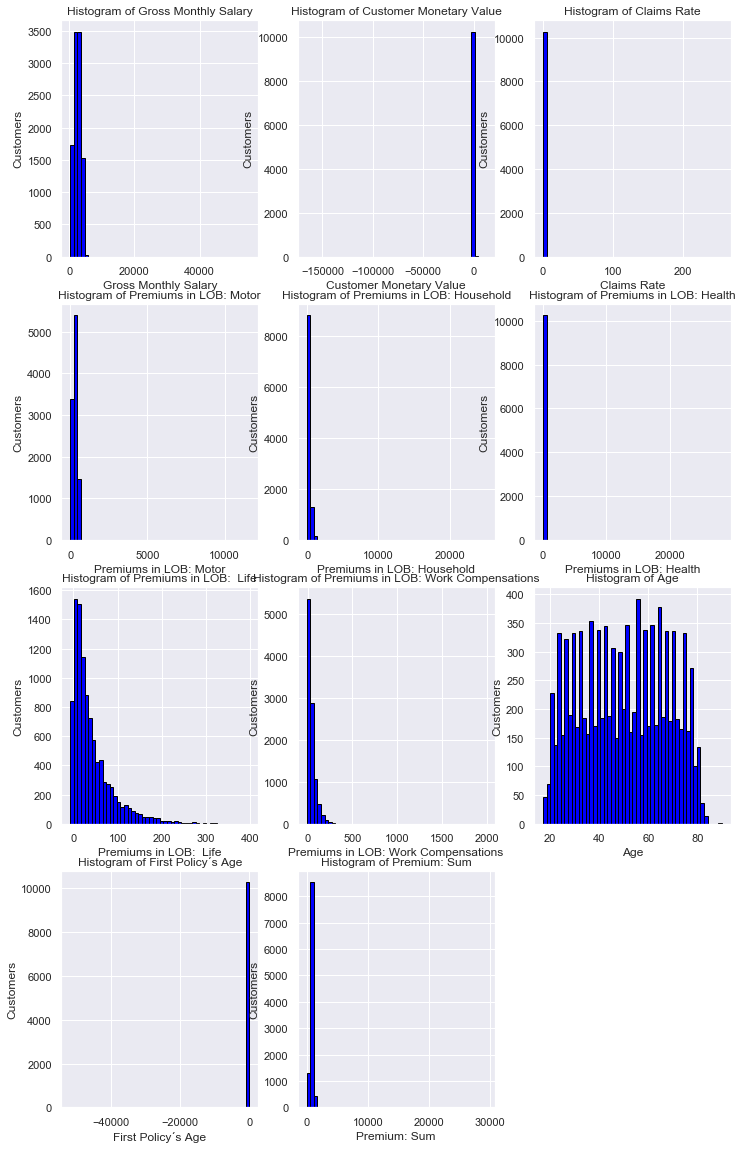

In [180]:
features = ['Gross Monthly Salary',
                          'Customer Monetary Value',
                          'Claims Rate',
                          'Premiums in LOB: Motor',
                          'Premiums in LOB: Household',
                          'Premiums in LOB: Health',
                          'Premiums in LOB:  Life',
                          'Premiums in LOB: Work Compensations',
                          'Age',
                          'First Policy´s Age',
                          'Premium: Sum']
histogram(insurance_df, features)

In [181]:
outliers = removeOutliers(insurance_df, 1.5, 3, features)

Gross Monthly Salary
Percentiles: 25th=1706.000, 75th=3290.250, IQR=1584.250
Identified outliers: 2
Customer Monetary Value
Percentiles: 25th=-9.440, 75th=399.778, IQR=409.218
Identified outliers: 25
Claims Rate
Percentiles: 25th=0.390, 75th=0.980, IQR=0.590
Identified outliers: 15
Premiums in LOB: Motor
Percentiles: 25th=190.590, 75th=408.300, IQR=217.710
Identified outliers: 6
Premiums in LOB: Household
Percentiles: 25th=49.450, 75th=290.050, IQR=240.600
Identified outliers: 123
Premiums in LOB: Health
Percentiles: 25th=111.800, 75th=219.820, IQR=108.020
Identified outliers: 4
Premiums in LOB:  Life
Percentiles: 25th=9.890, 75th=57.790, IQR=47.900
Identified outliers: 141
Premiums in LOB: Work Compensations
Percentiles: 25th=10.670, 75th=56.790, IQR=46.120
Identified outliers: 162
Age
Percentiles: 25th=35.000, 75th=65.000, IQR=30.000
Identified outliers: 0
First Policy´s Age
Percentiles: 25th=26.000, 75th=38.000, IQR=12.000
Identified outliers: 1
Premium: Sum
Percentiles: 25th=626.42

In [182]:
print(len(outliers))
print(insurance_df.shape[0])
print(len(outliers)/insurance_df.shape[0])

439
10296
0.04263791763791764


In [183]:
insurance_df.drop(outliers, inplace=True)
insurance_df.shape

(9857, 15)

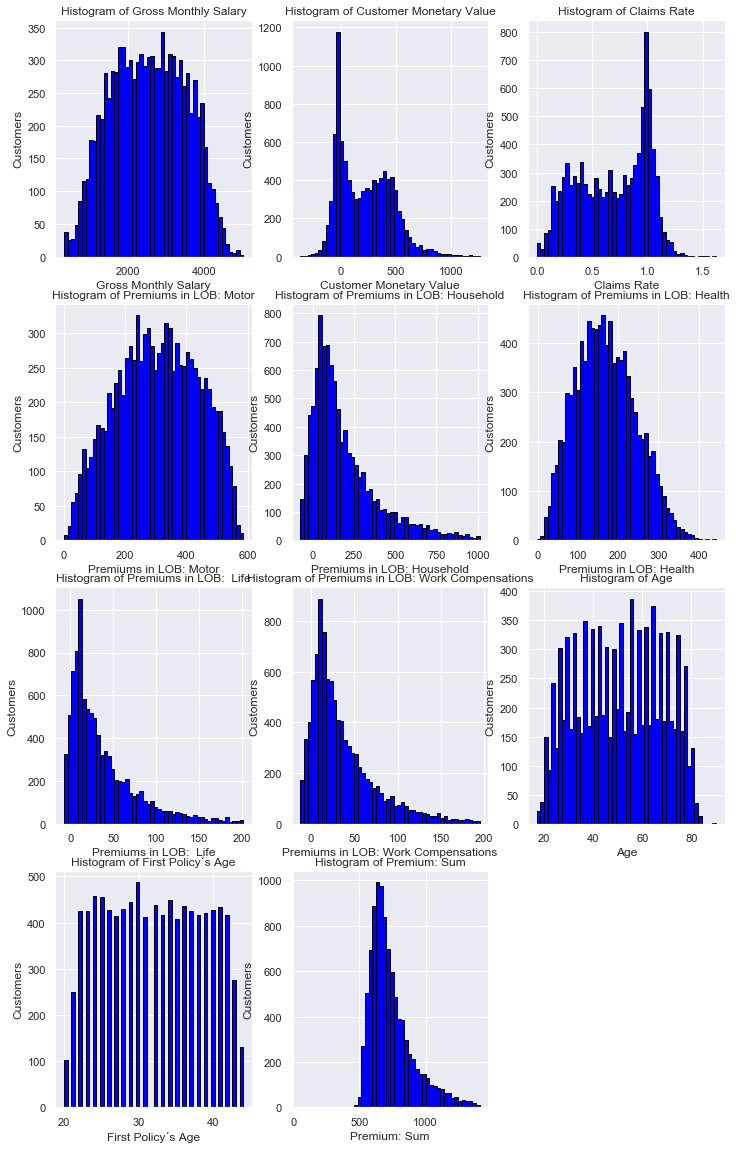

In [184]:
histogram(insurance_df, features)

In [185]:
#Drop rows with more than 3 NaN's
insurance_df.dropna(thresh=(len(insurance_df.columns) - 3), inplace=True, axis=0)
insurance_df.shape

(9857, 15)

In [186]:
#Counting the rows with 'First Policy´s Age' > 'Age'
#It shows us a possible problem with the data
insurance_df[insurance_df['First Policy´s Age'] > insurance_df['Age']].shape[0]

1702

In [187]:
#Proportion of customers below 18 that have children
#Is 'Age' trustworthy?
x = insurance_df[(insurance_df['Age'] <= 18) & (insurance_df['Has Children (Y=1)'] == 1)].shape[0]
y = insurance_df[(insurance_df['Age'] <= 18) & (insurance_df['Has Children (Y=1)'] == 0)].shape[0]
print("{:.2f}".format(x/(x+y)*100),'%')

77.27 %


In [188]:
data_insurance = deepcopy(insurance_df)

#Dropping row(s) with evident noisy (corrupted or distorted) values in the dataframe
#data_insurance.drop(env_params['NoisyData'], inplace=True)

#Encoding Educational Degree and returning back the NaN's
data_insurance['Educational Degree'] = data_insurance['Educational Degree'].apply(str)

labelencoder_X = LabelEncoder()

data_insurance.loc[:,'Educational Degree'] = labelencoder_X.fit_transform(data_insurance.loc[:,'Educational Degree'])

data_insurance['Educational Degree'] = data_insurance['Educational Degree'].apply(lambda x : np.nan if x == 4 else x )

In [189]:
data_insurance.tail()

,Customer Identity,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Age,First Policy´s Age,Premium: Sum
10289,10290,1.00,"3,498.00",4.00,0.00,245.60,0.67,227.82,270.60,160.92,100.13,69.90,75.00,32.00,829.37
10291,10292,3.00,"3,188.00",2.00,0.00,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,69.00,34.00,641.56
10293,10294,2.00,"2,918.00",1.00,1.00,524.10,0.21,403.63,132.80,142.25,12.67,4.89,42.00,24.00,696.24
10294,10295,0.00,"1,971.00",2.00,1.00,250.05,0.65,188.59,211.15,198.37,63.90,112.91,41.00,37.00,774.92
10295,10296,3.00,"2,815.00",1.00,1.00,463.75,0.27,414.08,94.45,141.25,6.89,12.89,37.00,28.00,669.56


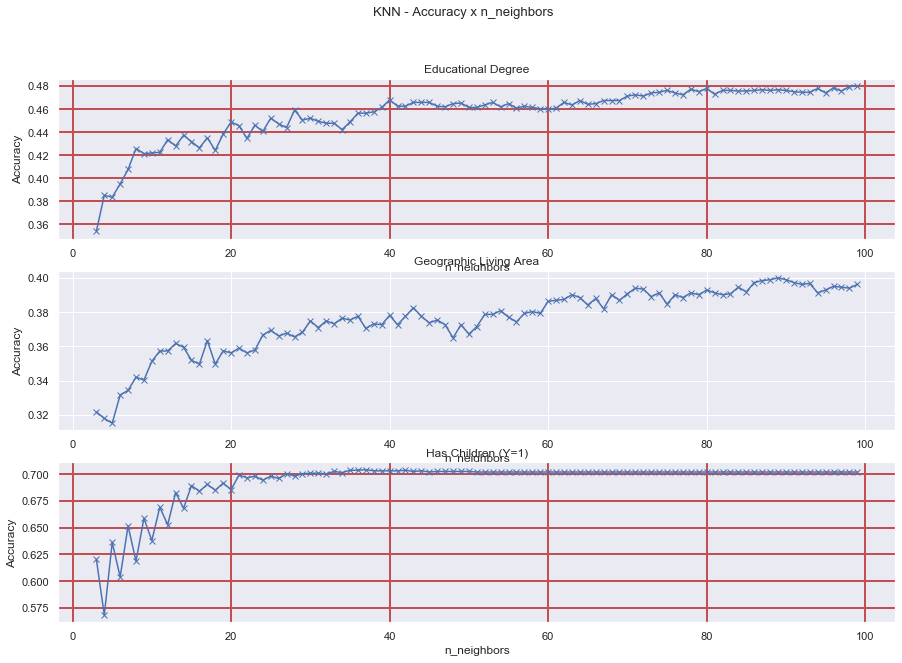

In [190]:
#Verify the optimal n_neighbors to our KNN classifiers
scaled_data_insurance = rescale(data_insurance)
scaled_data_insurance.drop('Customer Identity', axis=1)

accuracies_for_column_dict = evaluateClassifier(scaled_data_insurance)
fig, ax = plt.subplots(3, figsize=(15,10))
fig.suptitle('KNN - Accuracy x n_neighbors')
ax[0].plot(list(accuracies_for_column_dict['Educational Degree'].keys()),
                                    list(accuracies_for_column_dict['Educational Degree'].values()),
                                    'bx-') 
ax[0].set_title('Educational Degree')
ax[0].grid(True, which='both', color='r', linestyle='-', linewidth=2)

ax[1].plot(list(accuracies_for_column_dict['Geographic Living Area'].keys()),
                                    list(accuracies_for_column_dict['Geographic Living Area'].values()),
                                    'bx-') 
ax[1].set_title('Geographic Living Area')
ax[0].grid(True, which='both', color='r', linestyle='-', linewidth=2)

ax[2].plot(list(accuracies_for_column_dict['Has Children (Y=1)'].keys()),
                                    list(accuracies_for_column_dict['Has Children (Y=1)'].values()),
                                    'bx-') 
ax[2].set_title('Has Children (Y=1)')
ax[2].grid(True, which='both', color='r', linestyle='-', linewidth=2)

for ax in ax.flat:
    ax.set(xlabel='n_neighbors', ylabel='Accuracy')

plt.show()

In [191]:
#Considering we didn't achieve good estimations for the first two categorical columns, we will drop the rows which contain NaNs
#on these columns
data_insurance.dropna(subset=['Educational Degree', 'Geographic Living Area'], inplace=True)

#Setting the optimal number of neighbors to categorical column regression
n_neighbors_dict = {#'Educational Degree' : 8,
                    #'Geographic Living Area' : 11,
                    'Has Children (Y=1)' : 21}

In [192]:
#Fill categorical data with the KNN predicted Values
data_insurance = classifyCategoricalData(data_insurance, n_neighbors_dict)

In [193]:
#Check choices and errors
choices, errors = checking_choices(data_insurance)
errors

{'Test: 0': {'KN-Errors': [-0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223,
   -0.12607248356027223],
  'Linear-Errors': [-0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575,
   -0.002367186416642575],
  'SVR-Errors': [-2.473483688331443,
   -1.2399788323133478,
   -0.10448602877570967,
   -0.3017792341019152,
   -0.06118903973578638,
   -0.39812366232091456,
   -0.5310686119096901,
   -1.23

In [194]:
'''Fill numerical data with the best regressor algorithm - We decided not to use apply_regressors function anymore.
after checking the errors of choices we decided to use a genetic algorithm for getting better parameters using
decision tree regressor''' 
#data_insurance = apply_regressors(choices,data_insurance, env_params['NumericalColumns'])
#Full dataset


'Fill numerical data with the best regressor algorithm - We decided not to use apply_regressors function anymore.\nafter checking the errors of choices we decided to use a genetic algorithm for getting better parameters using\ndecision tree regressor'

<h2><center> Genetic Algorithms Results</center></h2>

Summarize:

- Gross Monthly Salary (Index 10) <br>
        Low R² - Discarded (Drop NaN's)
- Premiums in LOB: Motor (Index 13)<br>
        The best solution was Test 5 - [‘friedman_mse’,  min_sample_split=122, min_samples_leaf=1, max_features=3, max_depth=28] 
        Fitness: 0.8157 – R² ~ 81.57% 
- Premiums in LOB: Health (Index 15)<br>
        Low R² - Discarded (Drop NaN's)
- Premiums in LOB:  Life (Index 16)<br>
        The best solution was Test 4 - [‘friedman_mse’, 2, min_samples_leaf=3,  max_features=9, max_depth=9] 
        Fitness: 0.6286 – R² ~ 62.86% 
- Premiums in LOB: Work Compensations (Index 17)<br>
        Low R² - Discarded (Drop NaN's)
- First Policy´s Age (Index 19)<br>
        Low R² - Discarded (Drop NaN's)


In [195]:
'''This part of the code fill the NaN's on Columns Motor and Life Premiums with the best
result from Genetic Algorithm configuration'''

column_for_regress = {'Premiums in LOB: Motor':['friedman_mse', 122, 1,3, 28],
                      'Premiums in LOB:  Life': ['friedman_mse', 2, 3, 9, 9]}



for i in column_for_regress: 
    complete,incomplete = split(data_insurance)
    #Split in train-test data    
    X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != i].values,
                                                        complete.loc[:,i].values, test_size = 0.35, random_state = 1)
    
    
    regressor = DecisionTreeRegressor(criterion=column_for_regress[i][0],
                            min_samples_split =column_for_regress[i][1],
                            min_samples_leaf=column_for_regress[i][2],
                            max_features=column_for_regress[i][3],
                            max_depth=column_for_regress[i][4],
                            random_state=1,
                            )

    
    #Train the model
    trained_model = regressor.fit(X_train, 
                             y_train)
    
    #Make predictions
    incomplete_2 = deepcopy(incomplete)
    incomplete_2.loc[:, incomplete.columns != i] = incomplete_2.loc[:, 
                            incomplete.columns != i].apply(lambda row: row.fillna(row.mean()), axis=1)
    
    prediction = trained_model.predict(incomplete_2.loc[:,incomplete_2.columns != i])
    temp_df = pd.DataFrame(prediction.reshape(-1,1), columns = [i])
    
    col_ind = 0
    if i == 'Premiums in LOB: Motor':
        col_ind = -7
    elif i == 'Premiums in LOB:  Life':
        col_ind = -4
        
    #fill NaN's on data_arrivals_incomplete 
    for index in range(len(temp_df)):
        if np.isnan(incomplete.iloc[index,col_ind]):
            incomplete.iloc[index,col_ind] = temp_df[i][index]    
    
    y_pred = regressor.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    
    print(r2)
    
    #and filling the nan's on arrivals_df
    data_insurance = pd.concat([complete, incomplete])

    data_insurance.set_index(data_insurance['Customer Identity'] - 1, inplace=True)



0.8681863204849545
0.6008966695981938


<h4>The decision here is to drop all the NaNs left, since we cannot use a good prediction on the columns. Doing that we are losing 144 rows (1.44% of the dataset, what we considered as an OK choice)</h4>

In [196]:
data_insurance.dropna(inplace=True)

In [197]:
data_insurance.isna().sum()

Customer Identity                      0
Educational Degree                     0
Gross Monthly Salary                   0
Geographic Living Area                 0
Has Children (Y=1)                     0
Customer Monetary Value                0
Claims Rate                            0
Premiums in LOB: Motor                 0
Premiums in LOB: Household             0
Premiums in LOB: Health                0
Premiums in LOB:  Life                 0
Premiums in LOB: Work Compensations    0
Age                                    0
First Policy´s Age                     0
Premium: Sum                           0
dtype: int64

In [198]:
data_insurance

,Customer Identity,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Age,First Policy´s Age,Premium: Sum
Customer Identity,,,,,,,,,,,,,,,
0,1,1.00,"2,177.00",1.00,1.00,380.97,0.39,375.85,79.45,146.36,47.01,16.89,36.00,33.00,665.56
1,2,1.00,677.00,4.00,1.00,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,23.00,37.00,910.96
2,3,0.00,"2,277.00",3.00,0.00,504.67,0.28,206.15,224.50,124.58,86.35,99.02,48.00,27.00,740.60
3,4,2.00,"1,099.00",4.00,1.00,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,37.00,28.00,600.68
4,5,2.00,"1,763.00",4.00,1.00,35.23,0.90,338.62,47.80,182.59,18.78,41.45,45.00,32.00,629.24
5,6,1.00,"2,566.00",4.00,1.00,-24.33,1.00,440.75,18.90,114.80,7.00,7.67,62.00,32.00,589.12
6,7,1.00,"4,103.00",4.00,0.00,-66.01,1.05,156.92,295.60,317.95,14.67,26.34,75.00,39.00,811.48
7,8,1.00,"1,743.00",4.00,1.00,-144.91,1.13,248.27,397.30,144.36,66.68,53.23,44.00,30.00,909.84
8,9,2.00,"1,862.00",1.00,1.00,356.53,0.36,344.51,18.35,210.04,8.78,9.89,40.00,37.00,591.57


In [200]:
#Preparing to plot correlation
plot_data_insurance = deepcopy(data_insurance)
#plot_data_insurance.drop(env_params['Outliers'], inplace=True)
plot_data_insurance.drop('Customer Identity', axis=1, inplace=True)

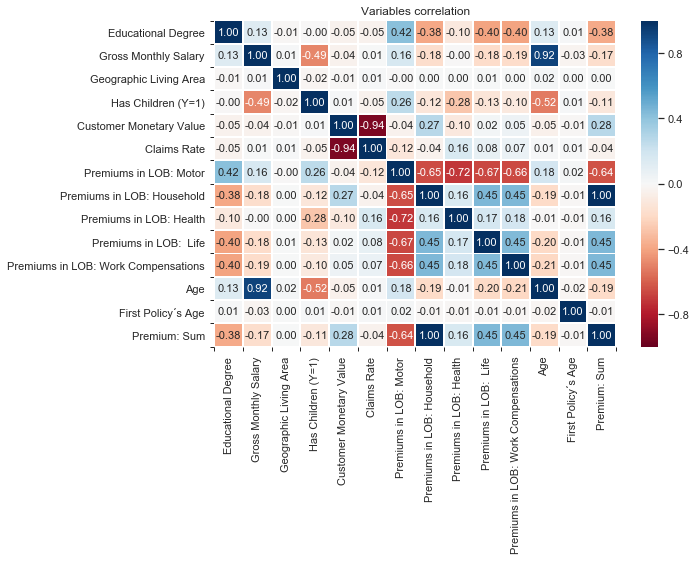

In [201]:
#Plotting the correlation between all variables
plotCorrelation(plot_data_insurance)

In [202]:
#Since 'Age' and 'Gross Monthly Salary' have a high correlation and 'Age' appears not to be trustworthy (described above),
#we'll drop the 'Age' column

plot_data_insurance.drop('Age', axis=1, inplace=True)
data_insurance.drop('Age', axis=1, inplace=True)

#Since 'Customer Monetary Value' and 'Claims Rate' have a high (inverse) correlation, we'll maintain only the CMV

plot_data_insurance.drop('Claims Rate', axis=1, inplace=True)
data_insurance.drop('Claims Rate', axis=1, inplace=True)

In [203]:
#Separating variables
InsCon, ValEng = separateVariables(plot_data_insurance)

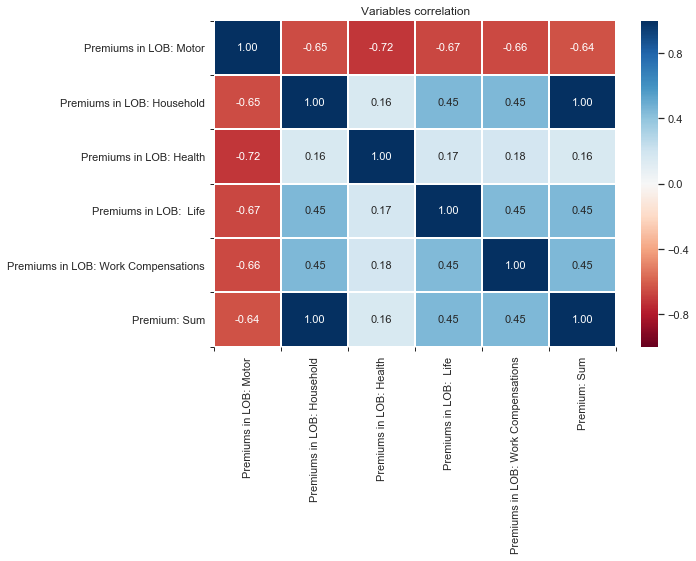

In [204]:
#Plotting the correlation between Insurance Consumption variables
plotCorrelation(InsCon)

In [205]:
#print(InsCon.mean(), '\n\n', InsCon.sum())

pd.options.display.float_format = '$ {:,.2f}'.format
ins_sum = pd.DataFrame(InsCon.sum(), columns=['Sum'])
ins_mean = pd.DataFrame(InsCon.mean(), columns=['Mean'])
ins_median = pd.DataFrame(InsCon.median(), columns=['Median'])
pd.concat([ins_sum, ins_mean, ins_median], axis=1, sort=False)


,Sum,Mean,Median
Premiums in LOB: Motor,"$ 2,945,215.76",$ 305.33,$ 307.28
Premiums in LOB: Household,"$ 1,844,924.60",$ 191.26,$ 128.90
Premiums in LOB: Health,"$ 1,641,113.59",$ 170.13,$ 165.03
Premiums in LOB: Life,"$ 366,624.99",$ 38.01,$ 24.56
Premiums in LOB: Work Compensations,"$ 357,539.00",$ 37.07,$ 24.67
Premium: Sum,"$ 7,154,165.69",$ 741.67,$ 694.57


In [206]:
pd.options.display.float_format = '{:,.2f}'.format

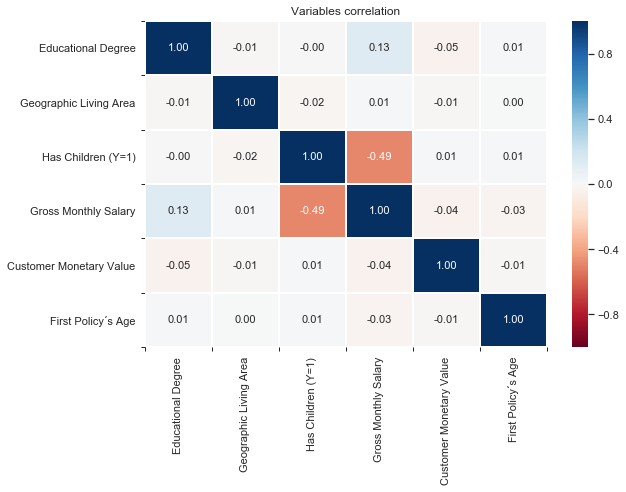

In [207]:
#Plotting the correlation between Customer Value & Engagement variables
plotCorrelation(ValEng)

In [269]:
def quartilePlotter(df, y_variables, x_variable):

    widths = [6, 6, 6]
    heights = [6, 6]    
    gs_kw = dict(width_ratios=widths, height_ratios=heights)

    f,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(18,12), gridspec_kw=gs_kw)
    #ax1.get_shared_y_axes().join(ax2,ax3)
    #ax4.get_shared_y_axes().join(ax5)
    
    g1 = sns.heatmap(quartileMatrix(df, y_variables[0], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax1)
    g1.set_ylabel(y_variables[0])
    g1.set_xlabel(x_variable)
    g1.set_ylim(4,0)
    g2 = sns.heatmap(quartileMatrix(df, y_variables[1], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax2)
    g2.set_ylabel(y_variables[1])
    g2.set_xlabel(x_variable)
    g2.set_yticks([])
    g3 = sns.heatmap(quartileMatrix(df, y_variables[2], x_variable),cmap="Greens", annot=True, fmt="d", cbar=False, ax=ax3)
    g3.set_ylabel(y_variables[2])
    g3.set_xlabel(x_variable)
    g3.set_yticks([])
    g4 = sns.heatmap(quartileMatrix(df, y_variables[3], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax4)
    g4.set_ylabel(y_variables[3])
    g4.set_xlabel(x_variable)
    g4.set_yticks([])
    g5 = sns.heatmap(quartileMatrix(df, y_variables[4], x_variable),cmap="Greens", annot=True, fmt="d", cbar=False, ax=ax5)
    g5.set_ylabel(y_variables[4])
    g5.set_xlabel(x_variable)
    g5.yaxis.tick_right()
    g5.set_ylim(4, 0)
    f.delaxes(ax6)
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    ax5.invert_yaxis()


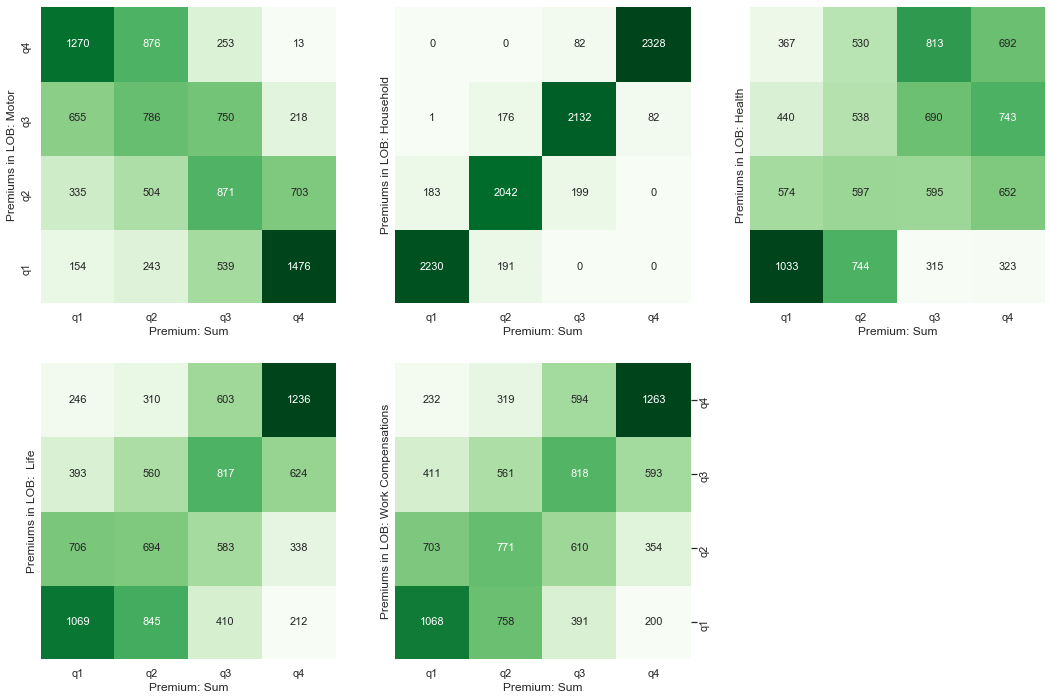

In [270]:
#Plotting the quartile matrix for Insurance Consumption features
#Show insurance type sales potential in relation to sum of premiums

y_variables = ['Premiums in LOB: Motor',
               'Premiums in LOB: Household',
               'Premiums in LOB: Health',
               'Premiums in LOB:  Life',
               'Premiums in LOB: Work Compensations']
x_variable = 'Premium: Sum'

quartilePlotter(InsCon, y_variables, x_variable)

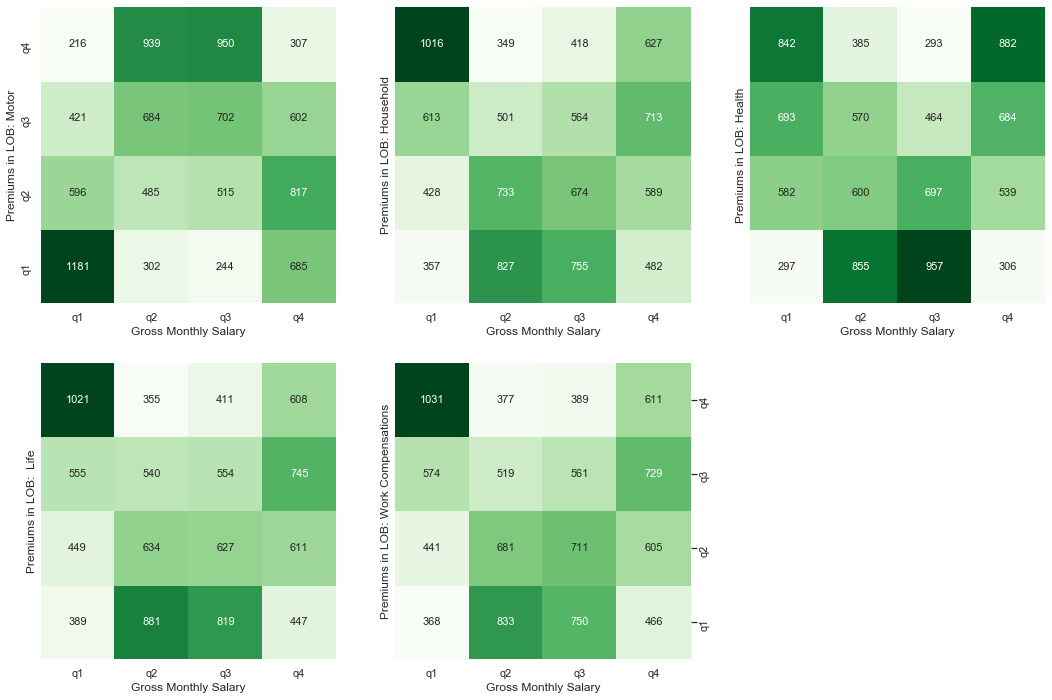

In [271]:
#Plotting the quartile matrix for Insurance Consumption features versus Salary
#Show insurance type sales potential in relation to salary

y_variables = ['Premiums in LOB: Motor',
               'Premiums in LOB: Household',
               'Premiums in LOB: Health',
               'Premiums in LOB:  Life',
               'Premiums in LOB: Work Compensations']
x_variable = 'Gross Monthly Salary'

quartilePlotter(plot_data_insurance, y_variables, x_variable)

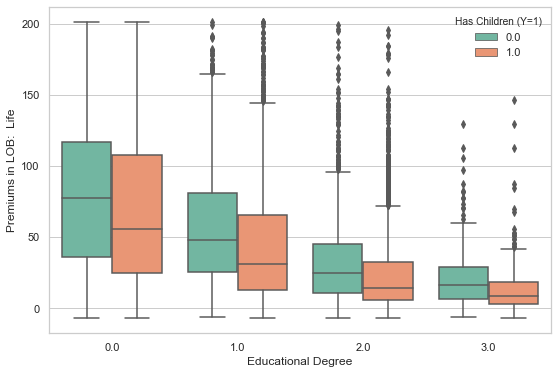

In [272]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(x='Educational Degree', y='Premiums in LOB:  Life', hue='Has Children (Y=1)', data=plot_data_insurance, palette="Set2")

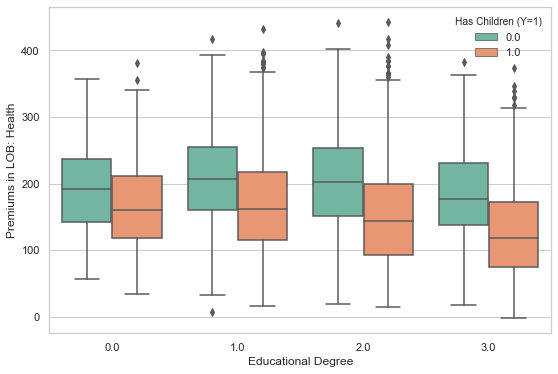

In [275]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(x='Educational Degree', y='Premiums in LOB: Health', hue='Has Children (Y=1)', data=plot_data_insurance, palette="Set2")

In [276]:
data_insurance.groupby(['Educational Degree','Geographic Living Area','Has Children (Y=1)'])['Claims Rate'].median().sort_values(ascending=False)

#data_insurance.groupby(['Geographic Living Area','Educational Degree','Has Children (Y=1)'])['Claims Rate'].median().sort_values(ascending=False)

#data_insurance.groupby(['Has Children (Y=1)','Educational Degree','Geographic Living Area'])['Claims Rate'].median().sort_values(ascending=False)





KeyError: 'Column not found: Claims Rate'

0
1
2
3
4
5
6
7
8
9


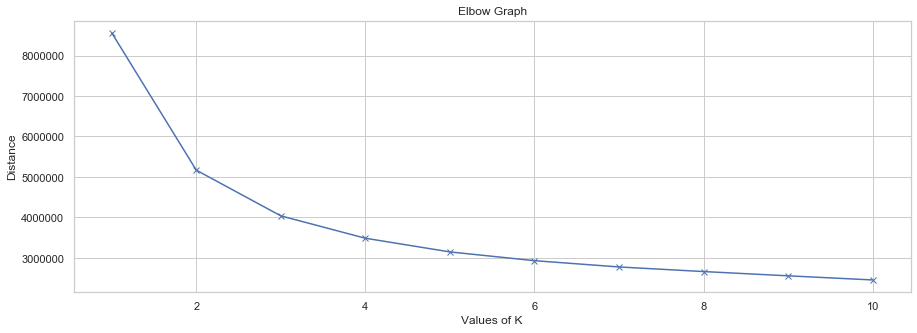

In [102]:
#Finding the number of clusters by the elbow graph.

K=list(range(1, 11))
list_distance = []

for aux in range(len(K)):
    centroids,labels,_ = k_means(data_insurance,n_clusters=K[aux],n_init=50,max_iter=200,n_jobs=-1)
    
    total_distance = 0

    L=[]
    my_labels = list(range(len(centroids)))

    j=0
    while j < len(my_labels):
        i=0
        while i < data_insurance.shape[0]:
            if labels[i] == my_labels[j]:
                newDistance=euclidean(centroids[j,:],data_insurance.iloc[i,:])
                L.append(newDistance)
            i = i+1
        j = j+1

    total_distance = sum(L)
    list_distance.append(total_distance)
    print(aux)
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(K, list_distance, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distance') 
plt.title('Elbow Graph') 
plt.show()

In [274]:
data_insurance.drop(['Customer Identity'],axis=1,inplace=True)

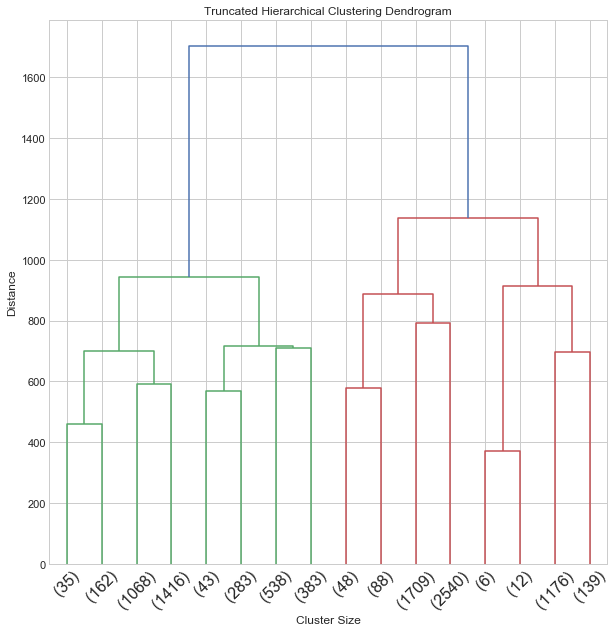

In [103]:
#Comparing with the number of clusters by the hierarchical clustering.

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,10))
Z = linkage(data_insurance,
            method='average',
            metric='euclidean',
            optimal_ordering=False)

dendrogram(Z,
           truncate_mode='level',
           p=3,
           orientation = 'top',
           leaf_rotation=45,
           leaf_font_size= 16,
           show_contracted=False,
           show_leaf_counts=True)

plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

plt.axhline(y=2500)
plt.show()

In [104]:
data_insurance

,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Claims Rate,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,First Policy´s Age,Premium: Sum
Customer Identity,,,,,,,,,,,,
0,1.00,"2,177.00",1.00,1.00,0.39,375.85,79.45,146.36,47.01,16.89,33.00,665.56
1,1.00,677.00,4.00,1.00,1.12,77.46,416.20,116.69,194.48,106.13,37.00,910.96
2,0.00,"2,277.00",3.00,0.00,0.28,206.15,224.50,124.58,86.35,99.02,27.00,740.60
3,2.00,"1,099.00",4.00,1.00,0.99,182.48,43.35,311.17,35.34,28.34,28.00,600.68
4,2.00,"1,763.00",4.00,1.00,0.90,338.62,47.80,182.59,18.78,41.45,32.00,629.24
5,1.00,"2,566.00",4.00,1.00,1.00,440.75,18.90,114.80,7.00,7.67,32.00,589.12
6,1.00,"4,103.00",4.00,0.00,1.05,156.92,295.60,317.95,14.67,26.34,39.00,811.48
7,1.00,"1,743.00",4.00,1.00,1.13,248.27,397.30,144.36,66.68,53.23,30.00,909.84
8,2.00,"1,862.00",1.00,1.00,0.36,344.51,18.35,210.04,8.78,9.89,37.00,591.57


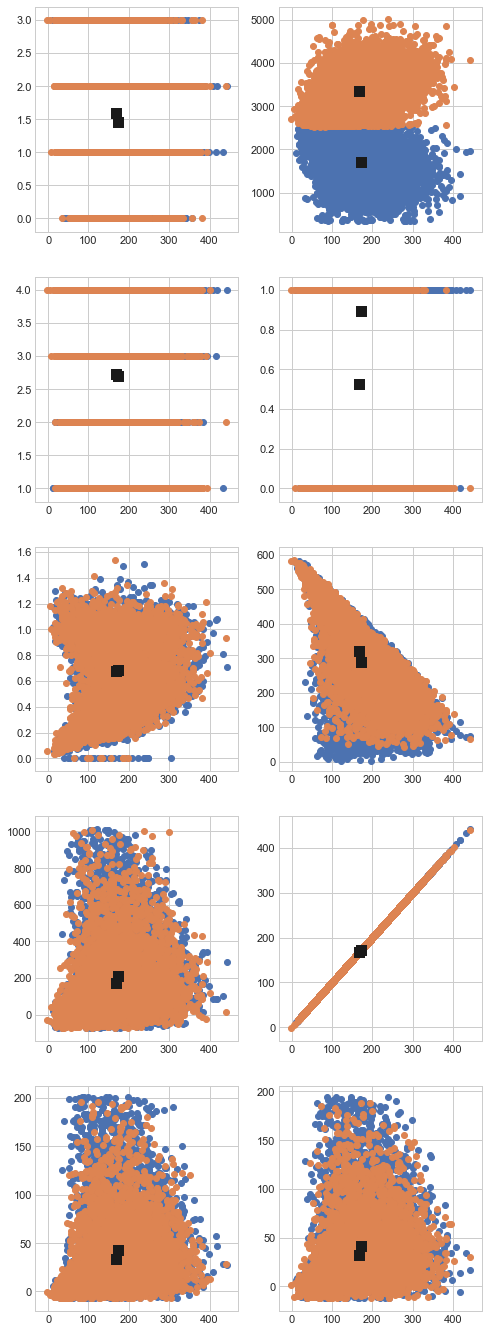

[[1.45063928e+00 1.71827080e+03 2.69838608e+00 8.95619367e-01
  6.80714735e-01 2.89222289e+02 2.12099067e+02 1.72928872e+02
  4.25647474e+01 4.17364839e+01 3.20387759e+01]
 [1.58646154e+00 3.34881087e+03 2.73025641e+00 5.25333333e-01
  6.78949744e-01 3.21094609e+02 1.70871785e+02 1.67398962e+02
  3.35484267e+01 3.24952269e+01 3.19267692e+01]]


In [106]:
ncl=2
dat_ins=data_insurance.drop(['Premium: Sum'],axis=1)

centroids,labels,_=k_means(dat_ins,n_clusters=ncl,n_init=50,max_iter=200,n_jobs=-1)
fig = plt.figure(figsize=(8, 24))

j=1
yl=dat_ins.columns[j]
#plt.show()
#plt.ylabel()
#plt.xlabel(data.columns[-1])
for j in range(10):
    
    ax = fig.add_subplot(5, 2, j + 1)
    for i in range(ncl):
        ax.scatter(dat_ins.iloc[labels==i,7],dat_ins.iloc[labels==i,j])
        ax.plot(centroids[:,7],centroids[:,j],'sk',markersize=10)
plt.show()
print(centroids)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(ncl):
    plt.scatter(dat_ins.iloc[labels==i,4],dat_ins.iloc[labels==i,5])
    #plt.scatter(dat_ins.iloc[labels==i,-4],dat_ins.iloc[labels==i,5])
    #plt.scatter(dat_ins.iloc[labels==i,-4],dat_ins.iloc[labels==i,6])
    #plt.scatter(dat_ins.iloc[labels==i,-4],dat_ins.iloc[labels==i,7])
    
plt.plot(centroids[:,4],centroids[:,5],'sk',markersize=15)
plt.show()
print(centroids)